In [18]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
from string import digits

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

import pandas as pd
import numpy as np
import string
import re
import random 
import os
import csv

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density

from scipy.stats import entropy
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuchenluo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Data and Clean

In [37]:
dat = pd.read_csv("all_text.csv")

In [31]:
#### preprocessing -------------------------------
punctuation_dictionary = {s:None for s in list(string.punctuation)}

punctuation_translator = str.maketrans(punctuation_dictionary)

stop_words = set(stopwords.words('english'))

# (remove punctuation, numbers, lowercase, stop words)
def text_cleaner_all(text, punctuation_translator):
    text = text.replace('c("', '')
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    text = ' '.join(filtered_text)
    return(text)

# (remove punctuation, lowercase, stop words)
def text_cleaner_mod(text, punctuation_translator):
    text = text.replace('c("', '')
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    text = ' '.join(filtered_text)
    return(text)

# (remove punctuation, lowercase)
def text_cleaner_min(text, punctuation_translator):
    text = text.replace('c("', '')
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    return(text)
# dat["clean_text"] = dat["text"].apply(lambda x: text_cleaner(x, punctuation_translator))

In [8]:
# find phrases
phrases1 = Phrases(map(lambda x: x.split(), dat["clean_text"].tolist())) #bigram
phrases2 = Phrases(phrases1[map(lambda x: x.split(), dat["clean_text"].tolist())]) #trigram
dat["phrased_text"] = dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

In [22]:
dat

,id,text,final_code,clean_text,phrased_text
0,7VS1-X791-2R2Y-70SK-00000-00.txt,"c(""May 23--Record demand for area food pantry ...",NaN,mayrecorddemandareafoodpantryprogramsoutpacing...,may 23record demand for area food_pantry progr...
1,4VGG-NH20-TX12-N12V-00000-00.txt,"c(""Jan. 28--STOCKTON -- All but six of the 189...",NaN,janstocktonsixunitsvintagesquareapartmentsrose...,jan 28stockton all but six of the 189 units in...
2,7VTR-NPY0-Y9J0-Y26V-00000-00.txt,"c(""May 31--It's a simple question: What are yo...",NaN,maysimplequestionchargedturnlightssitcomputert...,may 31its a simple_question what are you being...
3,4VG1-37N0-TX12-N0MF-00000-00.txt,"c(""Jan. 25--This is the best time for buying p...",NaN,janbesttimebuyingpropertiesabudhabisaysmdreale...,jan 25this is the best time for buying propert...
4,7WDR-PFY0-Y9J0-Y03G-00000-00.txt,"c(""Aug. 17--GLENS FALLS -- The Glens Falls Far...",NaN,augglensfallsglensfallsfarmersmarketbusyeverla...,aug 17glens falls the glens_falls farmers_mark...
...,...,...,...,...,...
214539,5P1D-JB81-DYY9-J17B-00000-00.txt,"""Change"" has been President-elect Barack Obama...",NaN,changepresidentelectbarackobamasmantramanysupp...,change has_been presidentelect_barack_obamas m...
214540,4V23-HR00-TXJ7-F169-00000-00.txt,As banks race to cover all of their payments b...,NaN,banksracecoverpaymentsbasesoneexcitingplayersw...,as banks race to cover all of their payments b...
214541,4TKS-1W10-TX2Y-F076-00000-00.txt,Media stocks might be depressed amid the curre...,NaN,mediastocksmightdepressedamidcurrentfinancialc...,media stocks might be depressed amid the curre...
214542,7WKK-W2D0-Y9S8-W524-00000-00.txt,Party leaders from both sides have condemned h...,NaN,partyleaderssidescondemnedoutburstimmigrationp...,party_leaders from both_sides have condemned h...


# doc2vec

In [78]:
# docs = list(zip(dat["phrased_text"].tolist(), dat["id"].tolist()))


# ## Define an iterator to feed documents and tags to Doc2Vec
# class Sentences(object):
#     def __init__(self, docs):
#         self.docs = docs
#     def __iter__(self):
#         for doc in self.docs:
#             yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

# ## Train and save models
# model = Doc2Vec(Sentences(docs), vector_size=100, window=10, min_count=100, negative=10, epochs=10, dm=0, dbow_words=1)

In [94]:
print(len(model.docvecs))
model.save("doc2vec_wordvecs.model")
print(len(docs))
print(len(dat))



214544
214544
214544


In [95]:
model.wv.most_similar('recession') #check the model

[('deep_recession', 0.8328547477722168),
 ('economic_slump', 0.823676347732544),
 ('severe_recession', 0.8173205852508545),
 ('recessionbut', 0.7941799163818359),
 ('current_downturn', 0.7936395406723022),
 ('recessionand', 0.7841596007347107),
 ('recessionary', 0.7790869474411011),
 ('prolonged_recession', 0.7782836556434631),
 ('downturn', 0.7760612964630127),
 ('recessionit', 0.7659202814102173)]

In [4]:
# load model
model = Word2Vec.load("doc2vec_wordvecs.model") 

# Random Forest

In [38]:
## load labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
# keep relavant rows and columns
clas_dat1 = clas_dat1[['id', 'text', 'final_code']]
clas_dat2 = pd.read_csv("random_sample3_CRK.csv")
clas_dat2 = clas_dat2[['id', 'text',"include"]]
clas_dat2.columns = clas_dat1.columns
clas_dat3 = pd.read_csv("random_sample2_YL.csv")
clas_dat3 = clas_dat3[['id', 'text',"match_yl"]]
clas_dat3.columns = clas_dat1.columns
clas_dat = clas_dat1.append([clas_dat2, clas_dat3])
# ## generate test and training set 
# clas_dat['test'] = np.random.choice([0, 1], size = len(clas_dat['id']), p = [0.8,0.2])
# merge with the total dataframe
dat = dat.merge(clas_dat[["id", "final_code"]], how = "left", on = "id")
X = np.asarray([model.docvecs[i] for i in dat[dat['id'].isin(clas_dat['id'])].index.tolist()])
y = clas_dat['final_code']

In [142]:
y.unique()

array([1, 0])

In [9]:
# split into training and testing 
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # tuning for RFC
# parameters = {'n_estimators':[500, 1000, 5000], 'max_depth':[3, 5, 10], "max_features": ["sqrt", 0.2, 0.5]}
# rfc = RandomForestClassifier()
# clf = GridSearchCV(rfc, parameters)
# clf.fit(X_train, y_train)
# print(clf.best_params_) 

# parameters = {'solver':["newton-cg", "ibfgs", "liblinear", "sag", "saga"], 'penalty':["none", "l1", "l2", "elasticnet"], "C": [100, 10, 1, 0.1, 0.01]}

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.522593 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [22]:
len(y_test)

180

In [156]:
# test RFC
rfc = RandomForestClassifier(n_estimators=5000, max_depth = 3, max_features ="sqrt")
## Fit the model to the training set
rfc.fit(X_train, y_train)
#PR AUC
preds = rfc.predict_proba(X_test)
lr_precision, lr_recall, _= precision_recall_curve(y_test.tolist(),  preds[:,1].tolist())
lr_auc = auc(lr_recall, lr_precision)
print(lr_auc)
confusion = confusion_matrix(y_test, rfc.predict(X_test))
print(confusion)
print(metrics.accuracy_score(y_test, rfc.predict(X_test)))

0.4640819202144156
[[42 49]
 [44 45]]
0.48333333333333334


In [146]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

[[49  9]
 [41 21]]
Precision: 0.700000
Recall: 0.338710
[[40 23]
 [36 21]]
Precision: 0.477273
Recall: 0.368421
[[43 16]
 [44 17]]
Precision: 0.515152
Recall: 0.278689
[[45 22]
 [32 21]]
Precision: 0.488372
Recall: 0.396226
[[48  5]
 [51 16]]
Precision: 0.761905
Recall: 0.238806
[[50 19]
 [29 22]]
Precision: 0.536585
Recall: 0.431373
[[48 10]
 [46 16]]
Precision: 0.615385
Recall: 0.258065
[[49 14]
 [37 20]]
Precision: 0.588235
Recall: 0.350877
[[37 28]
 [30 25]]
Precision: 0.471698
Recall: 0.454545
[[48 10]
 [48 14]]
Precision: 0.583333
Recall: 0.225806
Mean Accuracy: 0.5416666666666666
Average precision: 0.5737937819249062
Average recall: 0.3341517804174145


# bag of words + tfidf

In [52]:
### Max text cleaning (remove punctuation, numbers, lowercase, stop words) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_all(x, punctuation_translator))
# phrases1 = Phrases(map(lambda x: x.split(), clas_dat["clean_text"].tolist())) #bigram
# phrases2 = Phrases(phrases1[map(lambda x: x.split(), clas_dat["clean_text"].tolist())]) #trigram
# clas_dat["clean_text"] = clas_dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# classifier = RandomForestClassifier(n_estimators=1000,  max_depth = 3, max_features =0.5,random_state=0)
# classifier.fit(X_train, y_train) 
# y_pred = classifier.predict(X_test)

# print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
#     print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
#     print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
#     print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

Mean Accuracy: 0.7
Average precision: 0.6930884976441068
Average recall: 0.6920412161074508


In [33]:
### Moderate text cleaning (remove punctuation, lowercase, stop words) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_mod(x, punctuation_translator))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])

# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
#     print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
#     print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
#     print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

Mean Accuracy: 0.6883333333333334
Average precision: 0.6924507709947609
Average recall: 0.6900327937486975


In [34]:
### Minimum text cleaning (remove punctuation,lowercase) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_min(x, punctuation_translator))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])

# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
#     print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
#     print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
#     print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

Mean Accuracy: 0.6983333333333335
Average precision: 0.7212492088350276
Average recall: 0.684795987393603


In [35]:
### Minimum text cleaning (remove punctuation,lowercase) + Phrases --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_min(x, punctuation_translator))
phrases1 = Phrases(map(lambda x: x.split(), clas_dat["clean_text"].tolist())) #bigram
phrases2 = Phrases(phrases1[map(lambda x: x.split(), clas_dat["clean_text"].tolist())]) #trigram
clas_dat["clean_text"] = clas_dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])

# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
#     print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
#     print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
#     print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

Mean Accuracy: 0.6872222222222224
Average precision: 0.6792422704667211
Average recall: 0.702329471843471


# Logistic Regression Classifier (BOW+ Tf-Idf)

In [36]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = LogisticRegression(random_state=0, C= 1.0, penalty= 'l2', solver= 'liblinear').fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
#     print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
#     print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
#     print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

Mean Accuracy: 0.6861111111111111
Average precision: 0.6854323686252718
Average recall: 0.6815629221432726


In [41]:
#training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 

Best Accuracy: 0.709167 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.678136 (Accuracy: 0.676944) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.677745 (Accuracy: 0.676667) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.678136 (Accuracy: 0.676944) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.698054 (Accuracy: 0.693333) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.698205 (Accuracy: 0.693611) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.697337 (Accuracy: 0.693056) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.726299 (Accuracy: 0.704722) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.726299 (Accuracy: 0.704722) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.722218 (Accuracy: 0.702778) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.744178 (Accuracy: 0.703611) with: {'C':

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.672939 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.630882 (0.059695) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.630882 (0.059695) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.630895 (0.058816) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.653695 (0.061467) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.653695 (0.061467) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.652456 (0.061647) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.672939 (0.065714) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.672939 (0.065714) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.672235 (0.066668) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.627845 (0.049367) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.627845 (0.049367) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.634827 (0.054298) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.514613 (0.002171) wit

# SVM

In [77]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
# grid_result = grid.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [18]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = svm.SVC(C = 1, gamma= 0.1, kernel = "rbf")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

[[45 50]
 [34 51]]
Precision: 0.504950
Recall: 0.600000
[[50 41]
 [50 39]]
Precision: 0.487500
Recall: 0.438202
[[49 37]
 [45 49]]
Precision: 0.569767
Recall: 0.521277
[[43 54]
 [36 47]]
Precision: 0.465347
Recall: 0.566265
[[41 52]
 [38 49]]
Precision: 0.485149
Recall: 0.563218
[[54 45]
 [31 50]]
Precision: 0.526316
Recall: 0.617284
[[50 39]
 [34 57]]
Precision: 0.593750
Recall: 0.626374
[[48 44]
 [50 38]]
Precision: 0.463415
Recall: 0.431818
[[49 41]
 [52 38]]
Precision: 0.481013
Recall: 0.422222
[[45 42]
 [47 46]]
Precision: 0.522727
Recall: 0.494624
Mean Accuracy: 0.5211111111111111
Average precision: 0.5099933340990066
Average recall: 0.5281283930926547


In [21]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    gnb = GaussianNB()    
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))


[[42 42]
 [48 48]]
Precision: 0.533333
Recall: 0.500000
[[34 44]
 [47 55]]
Precision: 0.555556
Recall: 0.539216
[[47 36]
 [40 57]]
Precision: 0.612903
Recall: 0.587629
[[39 47]
 [41 53]]
Precision: 0.530000
Recall: 0.563830
[[36 54]
 [40 50]]
Precision: 0.480769
Recall: 0.555556
[[45 37]
 [41 57]]
Precision: 0.606383
Recall: 0.581633
[[36 46]
 [45 53]]
Precision: 0.535354
Recall: 0.540816
[[46 34]
 [50 50]]
Precision: 0.595238
Recall: 0.500000
[[52 33]
 [47 48]]
Precision: 0.592593
Recall: 0.505263
[[52 34]
 [53 41]]
Precision: 0.546667
Recall: 0.436170
Mean Accuracy: 0.5227777777777777
Average precision: 0.5588795214038866
Average recall: 0.531011224529602


# separate training set by coder

In [72]:
###### CARLY'S PORTION
## load labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
# keep relavant rows and columns
clas_dat1 = clas_dat1[['id', 'text', 'final_code']]
clas_dat2 = pd.read_csv("random_sample3_CRK.csv")
clas_dat2 = clas_dat2[['id', 'text',"include"]]
clas_dat2.columns = clas_dat1.columns
# clas_dat3 = pd.read_csv("random_sample2_YL.csv")
# clas_dat3 = clas_dat3[['id', 'text',"match_yl"]]
# clas_dat3.columns = clas_dat1.columns
# clas_dat4 = pd.read_csv('random_sample4.csv')
clas_dat = clas_dat1.append(clas_dat2)

### Max text cleaning (remove punctuation, numbers, lowercase, stop words) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_all(x, punctuation_translator))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])


#training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 

Best Accuracy: 0.729583 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.659427 (Accuracy: 0.677500) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.659427 (Accuracy: 0.677500) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.659144 (Accuracy: 0.677500) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.702105 (Accuracy: 0.709583) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.702105 (Accuracy: 0.709583) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.702114 (Accuracy: 0.710417) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.748412 (Accuracy: 0.729583) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.748412 (Accuracy: 0.729583) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.746675 (Accuracy: 0.729167) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.816216 (Accuracy: 0.695833) with: {'C':

In [75]:
###### YUCHEN'S PORTION
## load labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
# keep relavant rows and columns
clas_dat1 = clas_dat1[['id', 'text', 'final_code']]
# clas_dat2 = pd.read_csv("random_sample3_CRK.csv")
# clas_dat2 = clas_dat2[['id', 'text',"include"]]
# clas_dat2.columns = clas_dat1.columns
clas_dat3 = pd.read_csv("random_sample2_YL.csv")
clas_dat3 = clas_dat3[['id', 'text',"match_yl"]]
clas_dat3.columns = clas_dat1.columns
clas_dat4 = pd.read_csv('random_sample4.csv')
clas_dat = clas_dat1.append([clas_dat3, clas_dat4[0:99]])

### Max text cleaning (remove punctuation, numbers, lowercase, stop words) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_all(x, punctuation_translator))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])


#training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 

Best Accuracy: 0.703117 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.680315 (Accuracy: 0.641519) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.680315 (Accuracy: 0.641519) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.680107 (Accuracy: 0.641519) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.707138 (Accuracy: 0.674071) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.707138 (Accuracy: 0.674071) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.707172 (Accuracy: 0.674435) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.712705 (Accuracy: 0.703117) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.712705 (Accuracy: 0.703117) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.712490 (Accuracy: 0.703117) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.579393 (Accuracy: 0.583890) with: {'C':

# add in new training data

In [74]:
## load labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
# keep relavant rows and columns
clas_dat1 = clas_dat1[['id', 'text', 'final_code']]
# clas_dat2 = pd.read_csv("random_sample3_CRK.csv")
# clas_dat2 = clas_dat2[['id', 'text',"include"]]
# clas_dat2.columns = clas_dat1.columns
clas_dat3 = pd.read_csv("random_sample2_YL.csv")
clas_dat3 = clas_dat3[['id', 'text',"match_yl"]]
clas_dat3.columns = clas_dat1.columns
clas_dat4 = pd.read_csv('random_sample4.csv')
clas_dat = clas_dat1.append([clas_dat3, clas_dat4[0:99]])

### Max text cleaning (remove punctuation, numbers, lowercase, stop words) --------------------------
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner_all(x, punctuation_translator))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["clean_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])


#training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 

Best Accuracy: 0.680968 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.681717 (Accuracy: 0.628851) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.681717 (Accuracy: 0.628851) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.681322 (Accuracy: 0.628226) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.686114 (Accuracy: 0.642036) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.686114 (Accuracy: 0.642036) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.685685 (Accuracy: 0.642036) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.684558 (Accuracy: 0.680343) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.684558 (Accuracy: 0.680343) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.684754 (Accuracy: 0.680968) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.586190 (Accuracy: 0.586190) with: {'C':

# Remove Outliers

In [46]:
###### Isolation Forest ---------------------------

from sklearn.ensemble import IsolationForest

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize the shape of the training dataset
print(X_train.shape, y_train.shape)

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.005)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 
    
    
    
    
    
## -------------------- minimum covariance determinant 
# identify outliers in the training dataset
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 
    
    


(720, 500) (720,)
(716, 500) (716,)
Best Accuracy: 0.688877 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.656850 (Accuracy: 0.646142) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.657013 (Accuracy: 0.646424) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.657414 (Accuracy: 0.646980) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.685411 (Accuracy: 0.670192) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.685809 (Accuracy: 0.670469) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.686289 (Accuracy: 0.670743) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.706328 (Accuracy: 0.686385) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.706328 (Accuracy: 0.686385) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.704371 (Accuracy: 0.684984) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.679

/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10299.888678109849934 > -10303.358346807313865). You may want to try with a higher value of support_fraction (current value: 0.852).
  RuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10293.254919369232084 > -10293.868925075987136). You may want to try with a higher value of support_fraction (current value: 0.852).
  RuntimeWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171:

(708, 500) (708,)
Best Accuracy: 0.685348 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.648900 (Accuracy: 0.637320) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.649191 (Accuracy: 0.637320) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.648931 (Accuracy: 0.637324) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.682980 (Accuracy: 0.668157) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.683175 (Accuracy: 0.668439) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.683361 (Accuracy: 0.668720) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.704723 (Accuracy: 0.685348) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.704723 (Accuracy: 0.685348) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.703465 (Accuracy: 0.684503) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.674927 (Accuracy: 0.6

In [51]:
## -------------------- LOCAL OUTLIER FACTOR
# identify outliers in the training dataset
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 
    

(596, 500) (596,)
Best Accuracy: 0.705695 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.702944 (Accuracy: 0.681418) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.702944 (Accuracy: 0.681418) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.702341 (Accuracy: 0.680757) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.721465 (Accuracy: 0.697593) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.721465 (Accuracy: 0.697593) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.720520 (Accuracy: 0.696927) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.726092 (Accuracy: 0.704350) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.726092 (Accuracy: 0.704350) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.726173 (Accuracy: 0.705695) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.617405 (Accuracy: 0.6

In [59]:
## -------------------- ONE CLASS SVM
# identify outliers in the training dataset
from sklearn.svm import OneClassSVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# identify outliers in the training dataset
ee = OneClassSVM(nu=0.1)
yhat = ee.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# define grid search
scoring = ['accuracy', 'precision']

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring= ['accuracy', 'precision'],refit = "accuracy")
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
precisions = grid_result.cv_results_['mean_test_precision']
accuracys =  grid_result.cv_results_['mean_test_accuracy']
std_prec = grid_result.cv_results_['std_test_precision']
std_acc = grid_result.cv_results_['std_test_accuracy']
params = grid_result.cv_results_['params']

for prec, acc, param in zip(precisions, accuracys, params):
    print("Precision: %f (Accuracy: %f) with: %r" % (prec, acc, param)) 
    

(598, 500) (598,)
Best Accuracy: 0.703068 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.668877 (Accuracy: 0.652164) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.668877 (Accuracy: 0.652164) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.668877 (Accuracy: 0.652164) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.710149 (Accuracy: 0.688305) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.710149 (Accuracy: 0.688305) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.710149 (Accuracy: 0.688305) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.719766 (Accuracy: 0.702068) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Precision: 0.719766 (Accuracy: 0.702068) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Precision: 0.720326 (Accuracy: 0.703068) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.632597 (Accuracy: 0.6

# Active Learning

In [32]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density

# split into training and testing (can't bootstrap here)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

learner = ActiveLearner(
    estimator= RandomForestClassifier(n_estimators=1000, random_state=0),
    query_strategy=uncertainty_sampling,
    X_training=X_train, y_training=y_train
)

# generate the unlabelled pool
unlabelled = dat[((~dat['id'].isin(clas_dat.id)).tolist())]
X_pool = vectorizer.fit_transform(unlabelled["phrased_text"]).toarray()

tfidfconverter = TfidfTransformer()
X_pool = tfidfconverter.fit_transform(X_pool).toarray()


[115166 115198  41270  41234 114807  41141   1099 114682 115213  15511]


In [76]:
# # start the interactive active learning labeling session
# accuracy_scores_al = [learner.score(X_test, y_test)]
# X_pool_text = unlabelled['clean_text']

# for i in range(10):
#     query_idx, query_inst = learner.query(X_pool)
#     print(X_pool_text[query_idx])
#     y_new = np.array([int(input())], dtype=int)
#     learner.teach(query_inst, y_new)
#     X_pool = np.delete(X_pool, query_idx, axis=0)
#     accuracy_scores_al.append(learner.score(X_test, y_test))

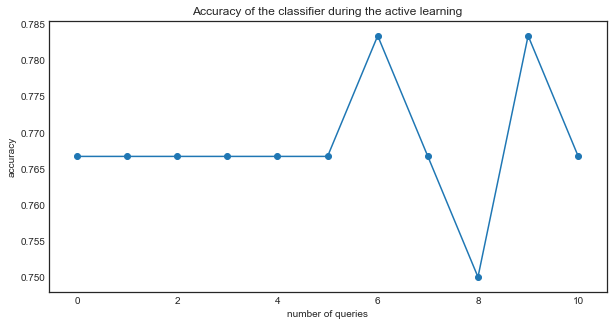

In [35]:
# visualize the results 
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(10+1), accuracy_scores_al)
    plt.scatter(range(10+1), accuracy_scores_al)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

# generate new sample

In [60]:
# labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
clas_dat2 = pd.read_csv("random_sample2.csv")
clas_dat3 = pd.read_csv("random_sample3.csv")

labelled_id = clas_dat1['id'].append(clas_dat2['id'])
labelled_id = labelled_id.append(clas_dat3['id'])

In [61]:
pool = dat[~dat['id'].isin(labelled_id)]
#sample3 = pool.sample(n = 300)
sample4 = pool.sample(n = 300)

In [63]:
sample4.to_csv("random_sample4.csv")

In [77]:
len(dat)

214544

In [62]:
len(pool)

213644

sample classification (balanced) 
active learning 
(not removing numbers) 
